### Differential cluster enrichment according to RECIST response

We investigated whether specific transcriptomic clusters were preferentially associated with clinical response to anti–PD-1 therapy, as defined by RECIST categories (PR vs SD).

For each Leiden cluster, the proportion of cells originating from PR and SD patients was calculated. Clusters were classified as **PR-enriched** or **SD-enriched** based on **relative enrichment (ratio ≥ 1.5 between conditions)** rather than relying on an arbitrary absolute cutoff. This approach allows identification of immune states preferentially associated with response while acknowledging that most clusters contain cells from both clinical groups.

---

### Marker-based biological interpretation of clusters

To interpret PR- and SD-enriched clusters, differential gene expression analysis was performed at the cluster level. Canonical immune markers were then used to assign **probable immune cell states** (e.g. naïve/memory T cells, cytotoxic T cells, NK cells, B cells, myeloid cells).

This annotation strategy is **heuristic and probabilistic** by design. It does not aim to define rigid cell identities, but rather to support biological interpretation of transcriptional programs enriched in each condition.

Importantly, the **same annotation framework and marker logic** were applied to both PR and SD clusters, ensuring fair and comparable interpretation across clinical groups.

---

### Saved outputs

The following results were saved for traceability and downstream analyses:

- Proportions of PR and SD cells per Leiden cluster  
- Marker genes for PR-enriched clusters  
- Marker genes for SD-enriched clusters  
- Final AnnData object including QC metrics, HVG selection, UMAP embedding, Leiden clustering, and clinical metadata  

These outputs constitute the final results of NB01.

---

### Next steps

Based on these global immune landscape results, subsequent analyses will focus on:
- Subsetting T cells from the full dataset  
- Comparing T-cell functional states between PR and SD patients  
- Investigating activation, cytotoxicity, and exhaustion programs in greater detail  

These steps will be conducted in a dedicated notebook (NB02) to ensure clear separation between global exploration and focused cell-type analyses.


In [2]:
# Project setup — set working directory to project root

# Step — Move working directory to project root

import os
os.chdir("..")
print("CWD after chdir:", os.getcwd())

CWD after chdir: c:\Users\yasmi\OneDrive\Desktop\Mini-Projets\scRNA_LUAD_Immunotherapy


In [15]:
# Sanity check — required files exist

from pathlib import Path

required = [
    "Data/GSE207422_NSCLC_scRNAseq_UMI_matrix.txt.gz",
    "Data/GSE207422_NSCLC_scRNAseq_metadata.xlsx",
    "Data/selected_cell_ids_40k.txt",
]

for p in required:
    print(p, "->", "OK" if Path(p).exists() else "MISSING")

Data/GSE207422_NSCLC_scRNAseq_UMI_matrix.txt.gz -> OK
Data/GSE207422_NSCLC_scRNAseq_metadata.xlsx -> OK
Data/selected_cell_ids_40k.txt -> OK


In [16]:
# Build cell-level metadata from UMI header, then select 40k cells (stratified)
# This does NOT load the full matrix. It only reads the header (cell IDs).

import gzip
import pandas as pd
import numpy as np
from pathlib import Path

np.random.seed(42)

umi_path  = Path("Data/GSE207422_NSCLC_scRNAseq_UMI_matrix.txt.gz")
meta_path = Path("Data/GSE207422_NSCLC_scRNAseq_metadata.xlsx")

meta = pd.read_excel(meta_path)

required_cols = ["Sample", "Patient", "Resource", "RECIST"]
missing = [c for c in required_cols if c not in meta.columns]
if missing:
    raise ValueError(f"Missing columns in metadata: {missing}")

meta = meta[required_cols].copy()

with gzip.open(umi_path, "rt", encoding="utf-8", errors="replace") as f:
    header = f.readline().rstrip("\n").split("\t")

cell_ids = header[1:]
print("Total cell IDs in matrix header:", len(cell_ids))

def cell_to_sample(cid: str) -> str:
    parts = cid.split("_")
    return "_".join(parts[:2]) if len(parts) >= 3 else parts[0]

cell_df = pd.DataFrame({"cell_id": cell_ids})
cell_df["Sample"] = cell_df["cell_id"].map(cell_to_sample)

cell_df = cell_df.merge(meta, on="Sample", how="inner")
print("Cells after matching to Sample metadata:", cell_df.shape[0])

cell_df["stratum"] = cell_df[["Patient", "Resource", "RECIST"]].astype(str).agg("|".join, axis=1)

target_n = 40000
counts = cell_df["stratum"].value_counts()
quotas = (counts / counts.sum() * target_n).round().astype(int)

diff = target_n - quotas.sum()
if diff != 0:
    for s in quotas.index[:abs(diff)]:
        quotas.loc[s] += 1 if diff > 0 else -1

parts = []
for s, q in quotas.items():
    if q <= 0:
        continue
    sub = cell_df[cell_df["stratum"] == s]
    if q >= len(sub):
        parts.append(sub)
    else:
        parts.append(sub.sample(n=q, random_state=42))

sel = pd.concat(parts, ignore_index=True)

print("Selected cells:", len(sel))
print("Selected patients:", sel["Patient"].nunique())
print("Resource distribution:\n", sel["Resource"].value_counts())
print("RECIST distribution:\n", sel["RECIST"].value_counts())

out_path = Path("Data/selected_cell_ids_40k.txt")
sel["cell_id"].to_csv(out_path, index=False, header=False)
print("Saved:", out_path)

Total cell IDs in matrix header: 92330
Cells after matching to Sample metadata: 92330
Selected cells: 40000
Selected patients: 15
Resource distribution:
 Resource
Post-treatment surgery    34073
Pre-treatment biopsy       5927
Name: count, dtype: int64
RECIST distribution:
 RECIST
PR    23635
SD    16365
Name: count, dtype: int64
Saved: Data\selected_cell_ids_40k.txt


In [17]:
# Extract 40k submatrix safely (write .txt first, then gzip)

import gzip
from pathlib import Path

in_path  = Path("Data/GSE207422_NSCLC_scRNAseq_UMI_matrix.txt.gz")
ids_path = Path("Data/selected_cell_ids_40k.txt")
out_txt  = Path("Data/UMI_40k_full.txt")
out_gz   = Path("Data/UMI_40k_full.txt.gz")

with open(ids_path, "r", encoding="utf-8") as f:
    keep_ids = set(line.strip() for line in f if line.strip())
print("Selected IDs:", len(keep_ids))

with gzip.open(in_path, "rt", encoding="utf-8", errors="replace") as fin:
    header = fin.readline().rstrip("\n").split("\t")

keep_idx = [0] + [i for i, cid in enumerate(header) if i > 0 and cid in keep_ids]
assert len(keep_idx) - 1 == 40000, f"Expected 40000 cells, got {len(keep_idx)-1}"
print("Keep indices OK:", len(keep_idx)-1)

with gzip.open(in_path, "rt", encoding="utf-8", errors="replace") as fin, \
    open(out_txt, "w", encoding="utf-8") as fout:

    fin.readline()  # discard header
    fout.write("\t".join([header[i] for i in keep_idx]) + "\n")

    for n, line in enumerate(fin, start=1):
        fields = line.rstrip("\n").split("\t")
        fout.write("\t".join(fields[i] for i in keep_idx) + "\n")
        if n % 2000 == 0:
            print("Written gene rows:", n)

print("Wrote:", out_txt)

with open(out_txt, "rb") as f_in, gzip.open(out_gz, "wb") as f_out:
    f_out.writelines(f_in)

print("Compressed:", out_gz)

Selected IDs: 40000
Keep indices OK: 40000
Written gene rows: 2000
Written gene rows: 4000
Written gene rows: 6000
Written gene rows: 8000
Written gene rows: 10000
Written gene rows: 12000
Written gene rows: 14000
Written gene rows: 16000
Written gene rows: 18000
Written gene rows: 20000
Written gene rows: 22000
Written gene rows: 24000
Wrote: Data\UMI_40k_full.txt
Compressed: Data\UMI_40k_full.txt.gz


In [3]:
# With this code, no need to run the three previous ones everytime. 
import scanpy as sc

adata = sc.read_text("Data/UMI_40k_full.txt", delimiter="\t").T
print(adata.shape)

(40000, 24292)


In [4]:
# Compute QC metrics and inspect basic distributions (no filtering)

import scanpy as sc

sc.pp.calculate_qc_metrics(adata, inplace=True)

adata.obs[["total_counts", "n_genes_by_counts"]].describe()

,total_counts,n_genes_by_counts
count,40000.000000,40000.000000
mean,6183.969727,1874.314925
std,7818.234375,1417.804479
min,614.000000,494.000000
25%,1683.000000,891.000000
50%,2549.000000,1255.000000
75%,7813.250000,2502.000000
max,94436.000000,9041.000000


In [5]:
# Apply QC filtering

sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_cells(adata, min_genes=500)
adata = adata[adata.obs["n_genes_by_counts"] <= 6000].copy()

print("Post-QC shape (cells, genes):", adata.shape)

Post-QC shape (cells, genes): (38484, 24292)


In [6]:
# Save post-QC AnnData object

adata.write("Data/adata_scRNA_40k_postQC.h5ad")
print("Saved: Data/adata_scRNA_40k_postQC.h5ad")

Saved: Data/adata_scRNA_40k_postQC.h5ad


In [7]:
# Normalize and log-transform (standard scRNA-seq preprocessing)

import scanpy as sc

adata = sc.read_h5ad("Data/adata_scRNA_40k_postQC.h5ad")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.write("Data/adata_scRNA_40k_postQC_log1p.h5ad")
print("Saved: Data/adata_scRNA_40k_postQC_log1p.h5ad", adata.shape)

Saved: Data/adata_scRNA_40k_postQC_log1p.h5ad (38484, 24292)


In [8]:
# Select highly variable genes (HVG) and save

import scanpy as sc

adata = sc.read_h5ad("Data/adata_scRNA_40k_postQC_log1p.h5ad")

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
print("HVG selected:", int(adata.var["highly_variable"].sum()))

adata.write("Data/adata_scRNA_40k_postQC_log1p_HVG.h5ad")
print("Saved: Data/adata_scRNA_40k_postQC_log1p_HVG.h5ad")

c:\Users\yasmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\legacy_api_wrap\__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVG selected: 2000
Saved: Data/adata_scRNA_40k_postQC_log1p_HVG.h5ad


In [9]:
# PCA, neighbors, UMAP, Leiden clustering, then save

import scanpy as sc

adata = sc.read_h5ad("Data/adata_scRNA_40k_postQC_log1p_HVG.h5ad")

# Use only HVGs for PCA/graph
adata_hvg = adata[:, adata.var["highly_variable"]].copy()

sc.pp.scale(adata_hvg, max_value=10)
sc.tl.pca(adata_hvg, svd_solver="arpack")
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_hvg)
sc.tl.leiden(adata_hvg, resolution=0.6)

print("UMAP computed. Leiden clusters:", adata_hvg.obs["leiden"].nunique())

adata_hvg.write("Data/adata_scRNA_40k_umap_leiden.h5ad")
print("Saved: Data/adata_scRNA_40k_umap_leiden.h5ad")

c:\Users\yasmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\yasmi\AppData\Local\Temp\ipykernel_2416\876445079.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=0.6)


UMAP computed. Leiden clusters: 22
Saved: Data/adata_scRNA_40k_umap_leiden.h5ad


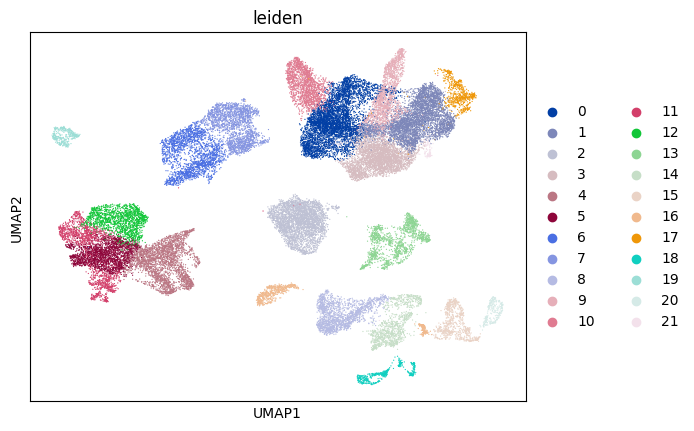

Saved figure to Results/figures (umap_leiden.png)


In [10]:
# Plot UMAP by Leiden and save figure

import scanpy as sc

sc.settings.figdir = "Results/figures"  # create this folder if needed
adata = sc.read_h5ad("Data/adata_scRNA_40k_umap_leiden.h5ad")

sc.pl.umap(adata, color="leiden", save="_leiden.png", show=True)

print("Saved figure to Results/figures (umap_leiden.png)")

In [11]:
# Merge clinical metadata (RECIST) into AnnData

import scanpy as sc
import pandas as pd

adata = sc.read_h5ad("Data/adata_scRNA_40k_umap_leiden.h5ad")

# Load metadata
meta = pd.read_excel("Data/GSE207422_NSCLC_scRNAseq_metadata.xlsx")

# Keep only what we need
meta = meta[["Sample", "RECIST"]].copy()

# Extract Sample from cell IDs (same logic as before)
def cell_to_sample(cid):
    parts = cid.split("_")
    return "_".join(parts[:2]) if len(parts) >= 3 else parts[0]

adata.obs["Sample"] = adata.obs_names.map(cell_to_sample)

# Merge
adata.obs = adata.obs.merge(meta, on="Sample", how="left")
adata.obs["RECIST"] = adata.obs["RECIST"].astype("category")

print(adata.obs["RECIST"].value_counts(dropna=False))

adata.write("Data/adata_scRNA_40k_umap_leiden_meta.h5ad")
print("Saved: Data/adata_scRNA_40k_umap_leiden_meta.h5ad")

c:\Users\yasmi\AppData\Local\Programs\Python\Python313\Lib\functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


RECIST
PR    22823
SD    15661
Name: count, dtype: int64
Saved: Data/adata_scRNA_40k_umap_leiden_meta.h5ad


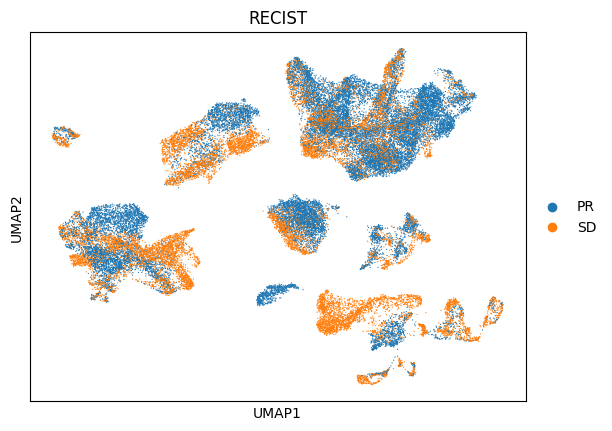

Saved figure: Results/figures/umap_RECIST.png


In [12]:
# Plot UMAP colored by RECIST and save

import scanpy as sc

sc.settings.figdir = "Results/figures"
adata = sc.read_h5ad("Data/adata_scRNA_40k_umap_leiden_meta.h5ad")

sc.pl.umap(adata, color="RECIST", save="_RECIST.png", show=True)

print("Saved figure: Results/figures/umap_RECIST.png")

In [15]:
# Quantify RECIST proportions per Leiden cluster

import pandas as pd
import scanpy as sc

adata = sc.read_h5ad("Data/adata_scRNA_40k_umap_leiden_meta.h5ad")

tab = (
    adata.obs
    .groupby(["leiden", "RECIST"])
    .size()
    .unstack(fill_value=0)
)

# Add proportions
tab_prop = tab.div(tab.sum(axis=1), axis=0)

print("Counts per cluster:")
display(tab)

print("\nProportions per cluster:")
display(tab_prop)

# Save
tab.to_csv("Results/RECIST_counts_per_cluster.csv")
tab_prop.to_csv("Results/RECIST_proportions_per_cluster.csv")

Counts per cluster:


C:\Users\yasmi\AppData\Local\Temp\ipykernel_2416\3374140698.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["leiden", "RECIST"])


RECIST,PR,SD
leiden,,
0,3310,1518
1,3831,437
2,2314,938
3,2578,622
4,752,1973
5,1234,1018
6,542,1523
7,1089,892
8,0,1755



Proportions per cluster:


RECIST,PR,SD
leiden,,
0,0.685584,0.314416
1,0.897610,0.102390
2,0.711562,0.288438
3,0.805625,0.194375
4,0.275963,0.724037
5,0.547957,0.452043
6,0.262470,0.737530
7,0.549722,0.450278
8,0.000000,1.000000


In [16]:
# Rank marker genes per Leiden cluster (Wilcoxon)

import scanpy as sc

adata = sc.read_h5ad("Data/adata_scRNA_40k_umap_leiden_meta.h5ad")

sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

# Save the ranked genes table
rg = sc.get.rank_genes_groups_df(adata, group=None)
rg.to_csv("Results/rank_genes_groups_leiden_all.csv", index=False)

print("Saved: Results/rank_genes_groups_leiden_all.csv")

c:\Users\yasmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\yasmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\yasmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\yasmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\yasmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: inv

Saved: Results/rank_genes_groups_leiden_all.csv


In [21]:
# Extract marker genes for PR- and SD-significant clusters (ratio ≥ 1.5)

import pandas as pd

# Load ranked genes
markers = pd.read_csv("Results/rank_genes_groups_leiden_all.csv")

# Define clusters (based on your criterion)
PR_clusters = ["0","1","2","3","10","12","13","16","17"]
SD_clusters = ["4","6","8","15","18","20","21"]

# Ensure group is string for matching
markers["group"] = markers["group"].astype(str)

# Subset markers
markers_PR = markers[markers["group"].isin(PR_clusters)]
markers_SD = markers[markers["group"].isin(SD_clusters)]

# Save
markers_PR.to_csv("Results/markers_PR_clusters_ratio1.5.csv", index=False)
markers_SD.to_csv("Results/markers_SD_clusters_ratio1.5.csv", index=False)

print("Saved:")
print(" - Results/markers_PR_clusters_ratio1.5.csv")
print(" - Results/markers_SD_clusters_ratio1.5.csv")

Saved:
 - Results/markers_PR_clusters_ratio1.5.csv
 - Results/markers_SD_clusters_ratio1.5.csv


In [22]:
markers_SD.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
8000,4,FBP1,81.06854,NaN,0.0,0.0
8001,4,MRC1,80.71884,NaN,0.0,0.0
8002,4,APOC1,78.37982,NaN,0.0,0.0
8003,4,ACP5,78.36797,NaN,0.0,0.0
8004,4,VIM,78.33896,NaN,0.0,0.0


In [23]:
markers_PR.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,IL7R,80.906425,NaN,0.0,0.0
1,0,SPOCK2,70.356186,NaN,0.0,0.0
2,0,TRAC,67.303620,NaN,0.0,0.0
3,0,CD3E,60.506275,NaN,0.0,0.0
4,0,TRBC2,59.858597,NaN,0.0,0.0


In [25]:
# Show + save TOP markers for all selected PR/SD clusters

import pandas as pd

markers_PR = pd.read_csv("Results/markers_PR_clusters_ratio1.5.csv")
markers_SD = pd.read_csv("Results/markers_SD_clusters_ratio1.5.csv")

# Keep top N markers per cluster (readable)
TOP_N = 50

top_PR = (markers_PR
        .sort_values(["group", "scores"], ascending=[True, False])
        .groupby("group")
        .head(TOP_N))

top_SD = (markers_SD
        .sort_values(["group", "scores"], ascending=[True, False])
        .groupby("group")
        .head(TOP_N))

# Display (all selected clusters, top markers each)
display(top_PR)
display(top_SD)

# Save for reporting
top_PR.to_csv("Results/top50_markers_PRclusters_ratio1.5.csv", index=False)
top_SD.to_csv("Results/top50_markers_SDclusters_ratio1.5.csv", index=False)

print("Saved:")
print(" - Results/top50_markers_PRclusters_ratio1.5.csv")
print(" - Results/top50_markers_SDclusters_ratio1.5.csv")

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,IL7R,80.906425,NaN,0.000000e+00,0.000000e+00
1,0,SPOCK2,70.356186,NaN,0.000000e+00,0.000000e+00
2,0,TRAC,67.303620,NaN,0.000000e+00,0.000000e+00
3,0,CD3E,60.506275,NaN,0.000000e+00,0.000000e+00
4,0,TRBC2,59.858597,NaN,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
16045,17,VIM,14.859767,NaN,6.013391e-50,2.312843e-48
16046,17,RGS1,14.690779,NaN,7.385999e-49,2.787169e-47
16047,17,IKZF3,14.502522,NaN,1.167803e-47,4.325195e-46
16048,17,SH2D1A,14.291459,NaN,2.473731e-46,8.995384e-45


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,4,FBP1,81.068540,NaN,0.000000,0.000000
1,4,MRC1,80.718840,NaN,0.000000,0.000000
2,4,APOC1,78.379820,NaN,0.000000,0.000000
3,4,ACP5,78.367970,NaN,0.000000,0.000000
4,4,VIM,78.338960,NaN,0.000000,0.000000
...,...,...,...,...,...,...
12045,21,ITM2A,3.794920,NaN,0.000148,0.002290
12046,21,FYB1,3.692227,NaN,0.000222,0.003318
12047,21,GPR183,3.681768,NaN,0.000232,0.003431
12048,21,MAF,3.585174,NaN,0.000337,0.004847


Saved:
 - Results/top50_markers_PRclusters_ratio1.5.csv
 - Results/top50_markers_SDclusters_ratio1.5.csv
